In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [6]:
class Statical_functions():
    def __init__(self):
        pass
    
    def read_data(self):
        
        """
        Read data from different file formats such as CSV, Excel, or JSON.

        Returns:
        - pd.DataFrame: The loaded dataset.
        """
        file_path = input("Please enter the path to the data file: ")
        file_extension = os.path.splitext(file_path)[1].lower()[1:]

        if file_extension == 'csv':
            return pd.read_csv(file_path)
        elif file_extension in ['xls', 'xlsx']:
            return pd.read_excel(file_path)
        elif file_extension == 'json':
            return pd.read_json(file_path)
        else:
            raise ValueError(f"Unsupported file format. Supported formats: CSV, Excel, JSON.")
    
    
    def drop_columns(self,data):
        print('wtite the columns to be droped: ')
        droped_columns=[]
        while True:
            droped_column = input('Write the column names you want to drop from the data. If you finish, press q: ')
        
            if droped_column == 'q':
                break
            droped_columns.append(droped_column)
        return data.drop(columns=droped_columns, axis=1)
    
    def statical_summary(self,data):
        print(data.head())
        print("##################Describeing the Data#################")
        print(data.describe())
        print("##################Columns in the Data#################")
        print(data.columns)
        print("##################before droping null values from the Data#################")
        print(data.isnull().sum())
        print('Drop null values')
        data=data.dropna()
        print("##################after droping null values from the Data#################")
        print(data.isnull().sum())
        
    

    def Handeling_missing_values(self,data):
        print('num of null in the data given : ')
        print(data.isnull().sum())
    
         # Separate numerical and categorical columns
        numerical_columns = data.select_dtypes(include=['number']).columns
        categorical_columns = data.select_dtypes(exclude=['number']).columns
    
        # Fill null values with mean for numerical columns
        for col in numerical_columns:
            if data[col].isnull().any():
                data[col].fillna(data[col].mean(), inplace=True)
    
        # Fill null values with median for categorical columns
        for col in categorical_columns:
            if data[col].isnull().any():
                data[col].fillna(data[col].mode()[0], inplace=True)

        print('After filling null values:')
        print(data.isnull().sum())

    
    def Categorical_Data_Encoding(self,data):
    
        # Initialize LabelEncoder and OneHotEncoder
        label_enc = LabelEncoder()
        onehot_enc = OneHotEncoder(drop='first', sparse=False)  # Drop first to avoid dummy variable trap

        # Separate numerical and categorical columns
        categorical_columns = data.select_dtypes(exclude=['number']).columns

        # Encode categorical columns using LabelEncoder
        for col in categorical_columns:
            if data[col].nunique() > 2:  # Use LabelEncoder for binary categorical columns
                data[col] = label_enc.fit_transform(data[col])
        
        # Apply OneHotEncoder to categorical columns with more than 2 unique values
        data_encoded = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
    
        return data_encoded
    
            
    
    

In [7]:
data=Statical_functions()

In [9]:
df=data.read_data()
#E:\ElectroPi\CustomerSegmentationforE-commercePersonalization\OnlineRetail.xlsx

Please enter the path to the data file: E:\ElectroPi\CustomerSegmentationforE-commercePersonalization\OnlineRetail.xlsx


In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
data.statical_summary(df)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
##################Describeing the Data#################
            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000

In [12]:
#data preprocessing 
#to get total price for each custumer
df['CustomerID'] = df['CustomerID'].astype(str)
df['Amount'] = df['Quantity']*df['UnitPrice']#total price for each unit
total_price = df.groupby('CustomerID')['Amount'].sum()#aggregates the total amount spent by each customer across all their transactions
total_price.reset_index()#to make 'CustomerID' column becomes a regular column again instead of being used as the index.
total_price.columns = ['CustomerID', 'Amount']
print(total_price)


CustomerID
12346.0          0.00
12347.0       4310.00
12348.0       1797.24
12349.0       1757.55
12350.0        334.40
              ...    
18281.0         80.82
18282.0        176.60
18283.0       2094.88
18287.0       1837.28
nan        1447682.12
Name: Amount, Length: 4373, dtype: float64


In [13]:
#calculates the frequency of transactions for each customer
freq_data = df.groupby('CustomerID')['InvoiceNo'].count()
freq_data = freq_data.reset_index()
freq_data.columns = ['CustomerID', 'Frequency']
print(freq_data)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70
4372        nan     135080

[4373 rows x 2 columns]


In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')#convert it to datetime format
max_date = max(df['InvoiceDate'])#give us the most recent date
df['Diff'] = max_date - df['InvoiceDate']#give us how recent each transaction occurred relative to the most recent date

transictions_amount = df.groupby('CustomerID')['Diff'].min()
#calculates the minimum value of the 'Diff' column within each group.
#This effectively gives us the minimum recency value for each customer, how recently each customer made a purchase.

transictions_amount = transictions_amount.reset_index()
transictions_amount.columns = ['CustomerID','Diff']

transictions_amount['Diff'] = transictions_amount['Diff'].dt.days
#extracts the number of days from the timedeltas in the 'Diff' column and assigns it back to the 'Diff' column.
#This ensures that the recency is represented in days rather than timedelta format.


print(transictions_amount)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42
4372        nan     0

[4373 rows x 2 columns]


In [15]:
#merge the new columns
New_data = pd.merge(total_price,freq_data,on='CustomerID',how='inner')
New_data = pd.merge(New_data,transictions_amount,on='CustomerID',how='inner')
New_data.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(New_data.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


In [16]:
Q1 = New_data.Amount.quantile(0.05)
Q3 = New_data.Amount.quantile(0.95)
IQR = Q3 - Q1
New_data = New_data[(New_data.Amount >= Q1 - 1.5*IQR) & (New_data.Amount <= Q3 + 1.5*IQR)]

Q1 = New_data.Recency.quantile(0.05)
Q3 = New_data.Recency.quantile(0.95)
IQR = Q3 - Q1
New_data = New_data[(New_data.Recency >= Q1 - 1.5*IQR) & (New_data.Recency <= Q3 + 1.5*IQR)]

Q1 = New_data.Frequency.quantile(0.05)
Q3 = New_data.Frequency.quantile(0.95)
IQR = Q3 - Q1
New_data = New_data[(New_data.Frequency >= Q1 - 1.5*IQR) & (New_data.Frequency <= Q3 + 1.5*IQR)]

In [20]:
print(New_data.shape)

(4294, 4)


In [21]:
#scaling
X = New_data[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
New_data_scaled = scaler.fit_transform(X)

In [23]:
New_data_scaled = pd.DataFrame(New_data_scaled)
New_data_scaled.columns = ['Amount', 'Frequency', 'Recency']
New_data_scaled.head()

,Amount,Frequency,Recency
0,0.235148,0.001395,0.871314
1,0.471523,0.252441,0.002681
2,0.333714,0.041841,0.198391
3,0.331538,0.100418,0.048257
4,0.253487,0.022315,0.828418


In [38]:
#Apply PCA
pca = PCA(n_components=3)  # Choose the number of components
rfm_ds_final_pca = pca.fit_transform(New_data_scaled)

In [39]:
# Optional: Check the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Step 3: Transform Data
rfm_ds_final_pca_df = pd.DataFrame(data=rfm_ds_final_pca, columns=['PC1', 'PC2','PC3'])

Explained Variance Ratio: [0.90756442 0.06205163 0.02157766]


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Zia

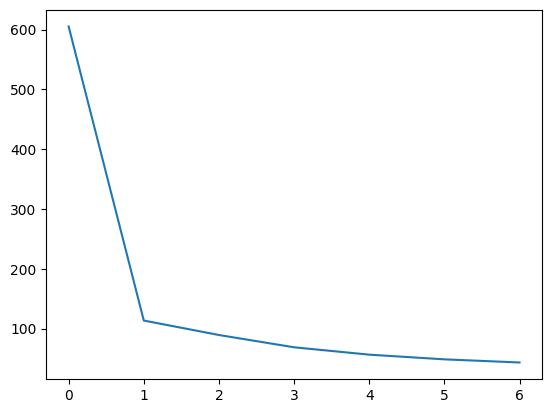

In [53]:
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(New_data_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

In [59]:
print('from the graph the best number of clusters will be 2 groups')

from the graph the best number of clusters will be 2 groups


<h1>Silhouette Analysis<h1>

silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)

𝑝 is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞 is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [54]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(New_data_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(New_data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=2, the silhouette score is 0.7885409931051954


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=3, the silhouette score is 0.8331298538659824


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=4, the silhouette score is 0.764871945705041


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=5, the silhouette score is 0.48672498330580954


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=6, the silhouette score is 0.45206313319915775


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=7, the silhouette score is 0.4331609362719618


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters=8, the silhouette score is 0.4204638858251661


In [60]:
kmeans = KMeans(n_clusters=2, max_iter=50)
kmeans.fit(New_data_scaled)
print(kmeans.labels_)
New_data_scaled['Cluster_Id'] = kmeans.labels_
New_data_scaled.head()

[1 1 0 ... 1 0 0]


C:\Users\Ziad\anaconda3\envs\vision\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Amount,Frequency,Recency,Cluster_Id
0,0.235148,0.001395,0.871314,1
1,0.471523,0.252441,0.002681,1
2,0.333714,0.041841,0.198391,0
3,0.331538,0.100418,0.048257,0
4,0.253487,0.022315,0.828418,1


<AxesSubplot: xlabel='Cluster_Id', ylabel='Amount'>

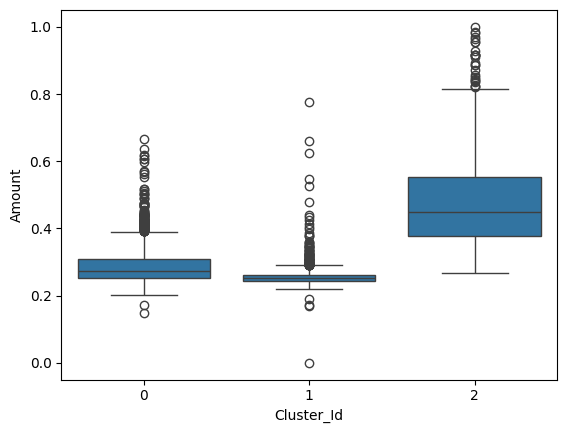

In [56]:
sns.boxplot(x='Cluster_Id', y='Amount', data=New_data_scaled)

In [61]:
print('it is clear that the most group buy a lot of prodects in cluster 2 then 0 then 1')

it is clear that the most group buy a lot of prodects in cluster 2 then 0 then 1


<AxesSubplot: xlabel='Cluster_Id', ylabel='Frequency'>

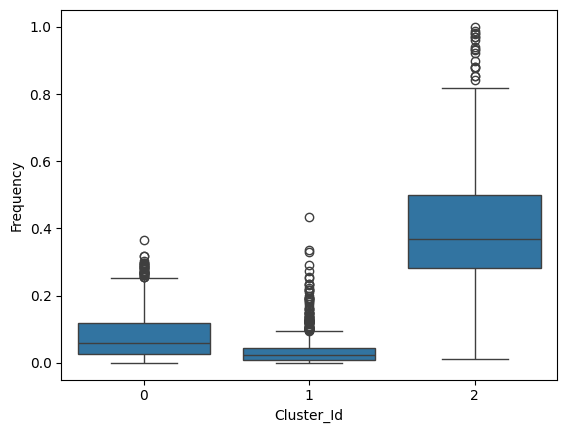

In [57]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=New_data_scaled)

In [62]:
print('it is clear that the most group has the most great value of frequency is cluster 2 then 0 then 1')

it is clear that the most group has the most great value of frequency is cluster 2 then 0 then 1


<AxesSubplot: xlabel='Cluster_Id', ylabel='Recency'>

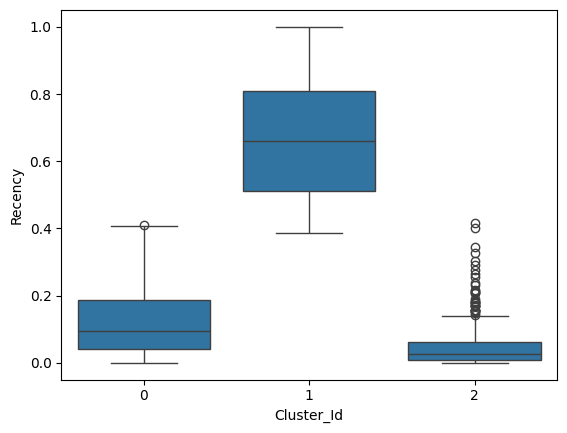

In [58]:
sns.boxplot(x='Cluster_Id', y='Recency', data=New_data_scaled)

In [63]:
print('it is clear that the most group who make the most recent process of buying is in cluster number 1 then number 0 then number 2')

it is clear that the most group who make the most recent process of buying is in cluster number 1 then number 0 then number 2
